# Setup

This project requires Python 3.7 or above

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn >= 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TenserFlow >= 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons

## The Perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)

In [7]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='perceptron', penalty=None, learning_rate='constant', eta0=1,
                        random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y=None, xlabel=None, ylabel=None):
    a = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_ / model.coef_[0, 1]
    axes = [0, 5, 0, 2]
    x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_pred = per_clf.predict(X_new)
    zz = y_pred.reshape(x0.shape)
    custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

    plt.figure(figsize=(7, 3))
    plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
    plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
    plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
            linewidth=3)
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.legend(loc="lower right")
    plt.axis(axes)
    plt.show()

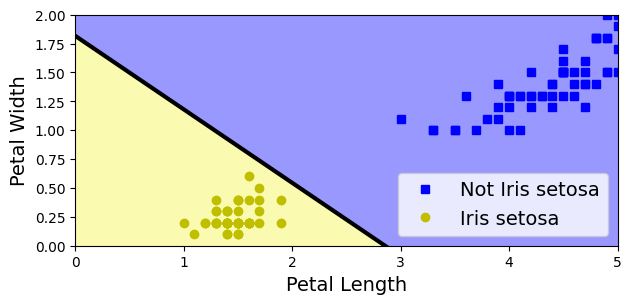

In [10]:
plot_decision_boundary(per_clf, X, y, 'Petal Length', 'Petal Width')

**Activation functions**

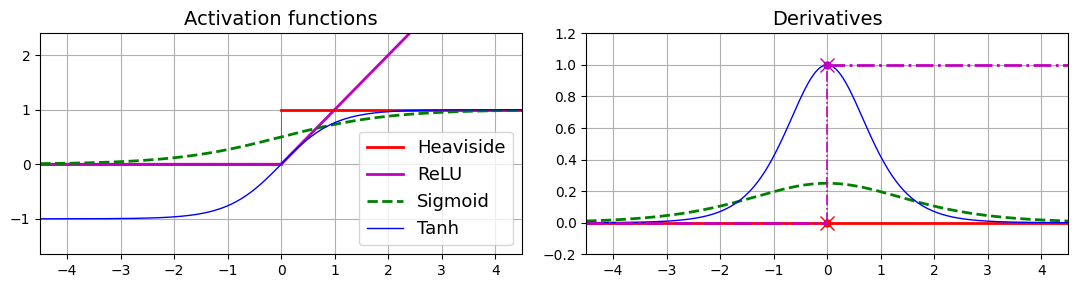

In [11]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, 
                                                              random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
                                                  random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.5053326657968725

## Classification MLPs

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier using the Sequential API
### Using Keras to load the dataset

In [14]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]

In [15]:
X_train.shape

(55000, 28, 28)

In [16]:
X_train.dtype

dtype('uint8')

In [17]:
X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

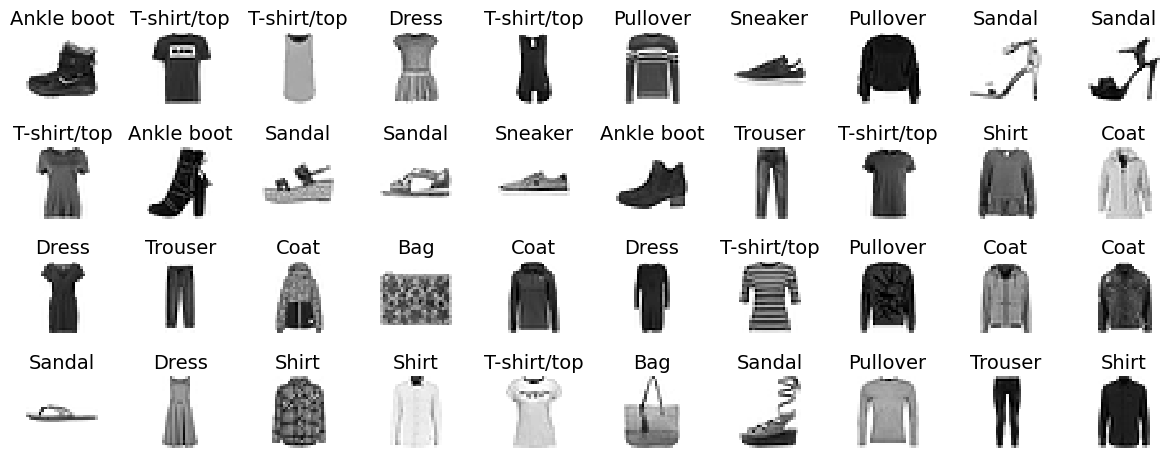

In [19]:
# extra code
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        idx = n_cols * row + col
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(X_train[idx], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[idx]])
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)

save_fig('fashion_mnist_plot')
plt.show()

### Creating the model using the Sequential API

In [20]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


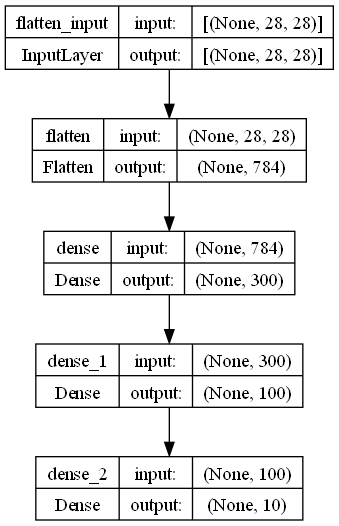

In [23]:
# another way to display the model's architecture
tf.keras.utils.plot_model(model, 'my_fashion_mnist_model.png', show_shapes=True)

In [24]:
model.layers

In [25]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [26]:
model.get_layer('dense') is hidden1

True

In [27]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.06458837, -0.07301977, -0.00631909, ...,  0.04104869,
        -0.07210203,  0.03743276],
       [-0.07429926, -0.07168459, -0.0245852 , ...,  0.02380627,
         0.05672099, -0.00927408],
       [ 0.00025757, -0.03343662,  0.02445747, ..., -0.05444173,
        -0.01521371,  0.07149526],
       ...,
       [ 0.04656602,  0.07164252,  0.01031779, ...,  0.02219325,
        -0.00966319,  0.00705773],
       [ 0.0619629 ,  0.00672623,  0.02286007, ..., -0.03949479,
        -0.0592522 ,  0.03218989],
       [-0.02706013, -0.05995248,  0.01410672, ...,  0.07351168,
         0.0228074 ,  0.0166319 ]], dtype=float32)

In [28]:
weights.shape

(784, 300)

In [29]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [30]:
biases.shape

(300,)

### Compiling the model

In [31]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [32]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0], dtype=int64)

If you want to convert sparse labels (i.e., class indices) to one-hot vector labels, use the `tf.keras.utils.to_categorical()` function. To go the other way round, use the `np.argmax()` function with axis=1.

### Training and evaluating the model

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30


1719/1719 [==============================] - 7s 3ms/step - loss: 0.7306 - accuracy: 0.7580 - val_loss: 0.5091 - val_accuracy: 0.8302
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4902 - accuracy: 0.8305 - val_loss: 0.4605 - val_accuracy: 0.8302
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4426 - accuracy: 0.8449 - val_loss: 0.4263 - val_accuracy: 0.8488
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4174 - accuracy: 0.8535 - val_loss: 0.3971 - val_accuracy: 0.8606
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3959 - accuracy: 0.8608 - val_loss: 0.3934 - val_accuracy: 0.8594
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3791 - accuracy: 0.8652 - val_loss: 0.3994 - val_accuracy: 0.8590
Epoch 7/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3667 - accuracy: 0.8689 - val_loss: 0.3710 - val_accuracy: 0.8684
Epo

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

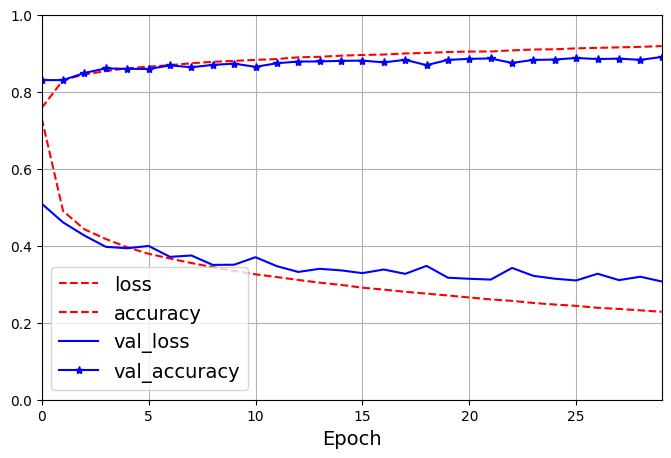

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*']
)
plt.legend(loc='lower left')
plt.show()

In [36]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3281 - accuracy: 0.8827


[0.32807615399360657, 0.8827000260353088]

### Using the model to make predictions

In [37]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 95ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [38]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [39]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [40]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

## Building a Regression MLP using the Sequential API

In [41]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [42]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=['RootMeanSquaredError'])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 0.8816 - root_mean_squared_error: 0.9390 - val_loss: 0.4890 - val_root_mean_squared_error: 0.6993
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3758 - root_mean_squared_error: 0.6130 - val_loss: 1.8543 - val_root_mean_squared_error: 1.3617
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3604 - root_mean_squared_error: 0.6004 - val_loss: 0.5893 - val_root_mean_squared_error: 0.7677
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3404 - root_mean_squared_error: 0.5835 - val_loss: 0.8534 - val_root_mean_squared_error: 0.9238
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3278 - root_mean_squared_error: 0.5725 - val_loss: 1.7535 - val_root_mean_squared_error: 1.3242
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3316 - root_mean_squared_error: 0.5759 - val_loss: 0.3943 - val_

In [43]:
rmse_test

0.531654417514801

In [44]:
y_pred

array([[0.45571148],
       [1.2368624 ],
       [5.0239515 ]], dtype=float32)

## Building Complex Models Using the Functional API

Not all neural networks are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network connects all or part of the inputs directly to the output layer.

In [45]:
# reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

*Wide & Deep neural network*

In [46]:
# the following 5 lines create all the layers we need to build the model
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

# next six lines use the above created layers to go from the input to the output
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

# NOTE: We are just telling Keras how it should connect the layers together; 
# no actual data is being processed yet, as the Input object is just a data specification.
# In other words, it's a symbolic input

# next line creates a Keras Model object by pointing to the input and the output
model = tf.keras.Model(inputs=[input_], outputs=[output])

- First, we create five layers: a `Normalization` layer to standardize the inputs, two `Dense` layers with 30 neurons each, using the `ReLU` activation function, a `Concatenate` layer, and one more `Dense` layer with a single neuron for the output layer, without any activation function.
- Next, we create an `Input` object (the variable name `input_` is used to avoid overshadowing Python's built-in `input()` function). This is a specification of the kind of input the model will get, including its shape and optionally its `dtype`, which defaults to 32-bit floats. A model may actually have multiple inputs.
- Then we use the `Normalization` layer just like a function, passing it the `Input` object. This is why this is called the `functional API`. Note that we are just telling Keras how it should connect the layers together; no actual data is being processed yet, as the `Input` object is just a data specification. In other words, it's a symbolic input. The output of this call is also symbolic input. The output of this call is also symbolic: `normalized` doesn't store any actual data, it's just used to construct the model.
- In the same way, we then pass `normalized` to `hidden_layer1`, which outputs `hidden1`, and we pass `hidden_layer2`, which outputs `hidden2`.
- So far we've connected the layers sequentially, but then we use the `concat_layer` to concatenate the input and the second hidden layer's output. Again, no actual data is concatenated yet: it's all symbolic, to build the model.
- Then we pass `concat` to the `output_layer`, which gives us the final output.
- Lastly, we create a `Keras Model`, specifying which inputs and outputs to use. 

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                              

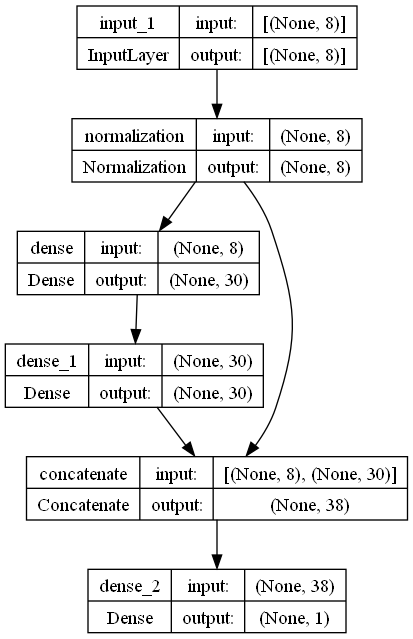

In [48]:
tf.keras.utils.plot_model(model, "California_housing_model.png", show_shapes=True)

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.2168 - root_mean_squared_error: 1.1031 - val_loss: 3.8718 - val_root_mean_squared_error: 1.9677
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4635 - root_mean_squared_error: 0.6808 - val_loss: 1.7691 - val_root_mean_squared_error: 1.3301
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3973 - root_mean_squared_error: 0.6303 - val_loss: 0.6606 - val_root_mean_squared_error: 0.8127
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3678 - root_mean_squared_error: 0.6065 - val_loss: 0.3569 - val_root_mean_squared_error: 0.5974
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3564 - root_mean_squared_error: 0.5970 - val_loss: 0.3305 - val_root_mean_squared_error: 0.5749
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3445 - root_mean_squared_error: 0.5870 - val_loss: 0.5141 - val_

In [50]:
tf.random.set_seed(42)

In [51]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.Concatenate()([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_val_wide, X_val_deep = X_val[:, :5], X_val[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_val_wide, X_val_deep), y_val))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 2s 5ms/step - loss: 1.6735 - root_mean_squared_error: 1.2936 - val_loss: 2.1520 - val_root_mean_squared_error: 1.4670
Epoch 2/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5083 - root_mean_squared_error: 0.7130 - val_loss: 0.5886 - val_root_mean_squared_error: 0.7672
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4294 - root_mean_squared_error: 0.6553 - val_loss: 0.4951 - val_root_mean_squared_error: 0.7037
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4095 - root_mean_squared_error: 0.6399 - val_loss: 0.6760 - val_root_mean_squared_error: 0.8222
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4073 - root_mean_squared_error: 0.6382 - val_loss: 0.7136 - val_root_mean_squared_error: 0.8447
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3925 - root_mean_squared_error: 0.6265 - val_loss: 1.0315 - val_

Instead of passing a tuple `(X_train_wide, X_train_deep)`, you can pass a dictionary `{"input_wide": X_train_wide, "input_deep": X_train_deep}`, if you set name="input_deep" when creating the inputs. This is highly recommended when there are many inputs, to clarify the code and avoid getting the order wrong.

Adding an auxiliary output for regularization

In [53]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [54]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.Concatenate()([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                        outputs=[output, aux_output])

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
                metrics=["RootMeanSquaredError"])

In [56]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val))
)

Epoch 1/20
363/363 [==============================] - 2s 5ms/step - loss: 1.3325 - dense_2_loss: 1.2427 - dense_3_loss: 2.1409 - dense_2_root_mean_squared_error: 1.1148 - dense_3_root_mean_squared_error: 1.4632 - val_loss: 0.7169 - val_dense_2_loss: 0.6818 - val_dense_3_loss: 1.0335 - val_dense_2_root_mean_squared_error: 0.8257 - val_dense_3_root_mean_squared_error: 1.0166
Epoch 2/20
363/363 [==============================] - 2s 4ms/step - loss: 0.4984 - dense_2_loss: 0.4712 - dense_3_loss: 0.7439 - dense_2_root_mean_squared_error: 0.6864 - dense_3_root_mean_squared_error: 0.8625 - val_loss: 1.1425 - val_dense_2_loss: 1.0406 - val_dense_3_loss: 2.0592 - val_dense_2_root_mean_squared_error: 1.0201 - val_dense_3_root_mean_squared_error: 1.4350
Epoch 3/20
363/363 [==============================] - 2s 4ms/step - loss: 0.4370 - dense_2_loss: 0.4217 - dense_3_loss: 0.5752 - dense_2_root_mean_squared_error: 0.6494 - dense_3_root_mean_squared_error: 0.7584 - val_loss: 0.3989 - val_dense_2_loss

In [57]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

  1/162 [..............................] - ETA: 3s - loss: 0.2686 - dense_2_loss: 0.2603 - dense_3_loss: 0.3437 - dense_2_root_mean_squared_error: 0.5102 - dense_3_root_mean_squared_error: 0.5863

162/162 [==============================] - 1s 4ms/step - loss: 0.3272 - dense_2_loss: 0.3212 - dense_3_loss: 0.3813 - dense_2_root_mean_squared_error: 0.5667 - dense_3_root_mean_squared_error: 0.6175


In [58]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 83ms/step


In [59]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 18ms/step


Both the sequential API and the functional API are declarative: you start by declaring which layers ypou want to use and how they should be connected, and only then can you start feeding the model some data for training or interference. This has many advantages: the model can easily be saved, cloned, and shared; its structure can be displayed and anlayzed; the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). It's also fairly straightforward to debug, since the whole model is a static graph of layers. But the flip side is just that: it's static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviours. For such cases, or simply if you prefer a more imperative programming style, the subclassing API is for you. 

## Using the Subclassing API to Build Dynamic Models

With this approach, you subclass the `Model` class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. For example, creating an instance of the following `WideAndDeepModel` class gives us an equivalent model to the one we just built with the Functional API.

In [60]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to suppoty naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
    
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.Concatenate()([hidden2, norm_wide])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")


In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
                metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))


Epoch 1/10
363/363 [==============================] - 3s 6ms/step - loss: 1.6834 - output_1_loss: 1.6179 - output_2_loss: 2.2732 - output_1_root_mean_squared_error: 1.2720 - output_2_root_mean_squared_error: 1.5077 - val_loss: 1.1355 - val_output_1_loss: 0.6706 - val_output_2_loss: 5.3205 - val_output_1_root_mean_squared_error: 0.8189 - val_output_2_root_mean_squared_error: 2.3066
Epoch 2/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5993 - output_1_loss: 0.5675 - output_2_loss: 0.8850 - output_1_root_mean_squared_error: 0.7533 - output_2_root_mean_squared_error: 0.9408 - val_loss: 1.5957 - val_output_1_loss: 1.5026 - val_output_2_loss: 2.4343 - val_output_1_root_mean_squared_error: 1.2258 - val_output_2_root_mean_squared_error: 1.5602
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4974 - output_1_loss: 0.4781 - output_2_loss: 0.6715 - output_1_root_mean_squared_error: 0.6914 - output_2_root_mean_squared_error: 0.8195 - val_loss: 0.514

## Saving and Restoring a Model

In [62]:
# delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [63]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


In [64]:
# show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model\assets
my_keras_model\keras_metadata.pb
my_keras_model\saved_model.pb
my_keras_model\variables
my_keras_model\variables\variables.data-00000-of-00001
my_keras_model\variables\variables.index


In [65]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 64ms/step


In [66]:
model.save_weights("my_weights")

In [67]:
model.load_weights("my_weights")

In [68]:
# show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


## Using Callbacks

In [69]:
shutil.rmtree("my_checkpoints", ignore_errors=True)

In [70]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val)),
    callbacks=[checkpoint_cb]
)

Epoch 1/10


363/363 [==============================] - 3s 8ms/step - loss: 0.3776 - output_1_loss: 0.3694 - output_2_loss: 0.4505 - output_1_root_mean_squared_error: 0.6078 - output_2_root_mean_squared_error: 0.6712 - val_loss: 0.4592 - val_output_1_loss: 0.4447 - val_output_2_loss: 0.5891 - val_output_1_root_mean_squared_error: 0.6669 - val_output_2_root_mean_squared_error: 0.7675
Epoch 2/10
363/363 [==============================] - 2s 6ms/step - loss: 0.3597 - output_1_loss: 0.3516 - output_2_loss: 0.4333 - output_1_root_mean_squared_error: 0.5929 - output_2_root_mean_squared_error: 0.6582 - val_loss: 0.5219 - val_output_1_loss: 0.4892 - val_output_2_loss: 0.8165 - val_output_1_root_mean_squared_error: 0.6994 - val_output_2_root_mean_squared_error: 0.9036
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3523 - output_1_loss: 0.3446 - output_2_loss: 0.4220 - output_1_root_mean_squared_error: 0.5870 - output_2_root_mean_squared_error: 0.6496 - val_loss: 0.3385 - val_out

In [71]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val)),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3408 - output_1_loss: 0.3354 - output_2_loss: 0.3895 - output_1_root_mean_squared_error: 0.5791 - output_2_root_mean_squared_error: 0.6241 - val_loss: 0.6814 - val_output_1_loss: 0.7012 - val_output_2_loss: 0.5034 - val_output_1_root_mean_squared_error: 0.8374 - val_output_2_root_mean_squared_error: 0.7095
Epoch 2/100
363/363 [==============================] - 2s 7ms/step - loss: 0.3397 - output_1_loss: 0.3339 - output_2_loss: 0.3926 - output_1_root_mean_squared_error: 0.5778 - output_2_root_mean_squared_error: 0.6266 - val_loss: 0.6100 - val_output_1_loss: 0.6135 - val_output_2_loss: 0.5791 - val_output_1_root_mean_squared_error: 0.7832 - val_output_2_root_mean_squared_error: 0.7610
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3313 - output_1_loss: 0.3256 - output_2_loss: 0.3826 - output_1_root_mean_squared_error: 0.5706 - output_2_root_mean_squared_error: 0.6185 - val_loss: 0.

Custom callbacks

In [72]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [73]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val)),
    callbacks=[val_train_ratio_cb], verbose=0
)

Epoch=0, val/train=0.99
Epoch=1, val/train=2.33
Epoch=2, val/train=1.13
Epoch=3, val/train=1.39
Epoch=4, val/train=2.61
Epoch=5, val/train=4.98
Epoch=6, val/train=2.90
Epoch=7, val/train=18.06
Epoch=8, val/train=8.43
Epoch=9, val/train=1.44


## Using TensorBoard for Visualization

In [74]:
shutil.rmtree("my_logs", ignore_errors=True)

In [75]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [76]:
# builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [77]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_cb])

Epoch 1/20
363/363 [==============================] - 2s 5ms/step - loss: 1.5041 - root_mean_squared_error: 1.2264 - val_loss: 0.7680 - val_root_mean_squared_error: 0.8764
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4619 - root_mean_squared_error: 0.6796 - val_loss: 0.5121 - val_root_mean_squared_error: 0.7156
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4051 - root_mean_squared_error: 0.6364 - val_loss: 0.5042 - val_root_mean_squared_error: 0.7101
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3824 - root_mean_squared_error: 0.6184 - val_loss: 0.4169 - val_root_mean_squared_error: 0.6457
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3663 - root_mean_squared_error: 0.6052 - val_loss: 0.4212 - val_root_mean_squared_error: 0.6490
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3567 - root_mean_squared_error: 0.5972 - val_loss: 0.3401 - val_

In [78]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

If you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [79]:
if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

# Fine-Tuning Neural Network Hyperparameters

In [80]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]

In [81]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [82]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                            sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                    metrics=["accuracy"])
    return model

The first part of the function defines the hyperparameters. For example, `hp.Int("n_hidden", min_value=0, max_value=8, default=2)` checks whether a hyperparameter named `"n_hidden"` is already present in the `HyperParameters` object `hp`, and if so it returns its value. If not, then it registers a new integer hyperparameter named `"n_hidden"`, whose possible values range from 0 to 8 (inclusive), and it returns the default value, which is 2 in this case (when `default` is not set, then `min_value` is returned). The `"n_neurons"` hyperparameter is registered as a float ranging from $10^{-4}$ to $10^{-2}$, and since `sampling="log"`, learning rates of all scales will be sampled equally. Lastly, the optimizer hyperparameter is registered with two possible values: `"sgd"` or `"adam"` (the default value is the first one, which is `"sgd"` in this case). Depending on the the value of `optimizer`, we create an `SGD optimizer` or an `Adam optimizer` with the given learning rate.

The second part of the function just builds the model using the hyperparameter values. It creates a `Sequential` model starting with a `Flatten` layer, followed by the requested number of hidden layers (as determined by the `n_hidden` hyperparameter) using the `ReLU` activation function, and an output layer with 10 neurons (one per class) using the softmax activation function. Lastly, the function compiles the model and returns it.

In [83]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashiion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                            validation_data=(X_val, y_val))

Trial 5 Complete [00h 00m 59s]
val_accuracy: 0.8407999873161316

Best val_accuracy So Far: 0.8586000204086304
Total elapsed time: 00h 05m 15s
INFO:tensorflow:Oracle triggered exit


In [84]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [85]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values   # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [86]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8586000204086304


In [87]:
best_trial.metrics.get_last_value("val_accuracy")

0.8586000204086304

In [88]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10


1875/1875 [==============================] - 7s 3ms/step - loss: 0.3254 - accuracy: 0.8805
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3161 - accuracy: 0.8842
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3074 - accuracy: 0.8875
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3002 - accuracy: 0.8898
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2945 - accuracy: 0.8920
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2879 - accuracy: 0.8939
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2826 - accuracy: 0.8953
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2763 - accuracy: 0.8981
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2712 - accuracy: 0.8989
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3969 - accuracy:

In some cases you may want to fine-tune data preprocessing hyperparameters, or `model.fit()` arguments, such as the batch size. For this, you must use a slightly different technique: instead of writing a `build_model()` function, you must subclass the `kt.HyperModel` class and define two methods, `build()` and `fit()`. The `build()` method does the exact same thing as the `build_model()` function. The `fit()` method takes a `Hyperparameters` object and a compiled model as an argument, as well as takes all the `model.fit()` arguments, and fits the model and returns the `History` object. Crucially, the `fit()` method may use hyperparameters to decide how to preprocess the data, tweak the batch size, and more. For example, the following class builds the same model as before, with the same hyperparameters, but it also uses a Boolean `"normalize"` hyperparameter to control whether or not to standardize the training data before fitting the model:

In [89]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)
    
    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [90]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband"
)

In [91]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_val, y_val),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 56s]
val_accuracy: 0.8461999893188477

Best val_accuracy So Far: 0.881600022315979
Total elapsed time: 00h 22m 04s
INFO:tensorflow:Oracle triggered exit


In [92]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4,beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt"
)
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_val, y_val),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.843999981880188

Best val_accuracy So Far: 0.8619999885559082
Total elapsed time: 00h 07m 24s
INFO:tensorflow:Oracle triggered exit


# Excercise

### 3. Why is it generally preferable to use a logistic regression classifier rather than a classic perceptron (i.e., a single layer of threshold logics unit trained using the perceptron training algorithm)? How can you tweak a perceptron to make it equivalent to a logistic regression classifier? 

Perceptron fails when the data given is not linearly separable whereas the logistic regression works in such cases. To make perceptron equivalent to logistic regression classifier we can change the activation function from heavisde to sigmoid activation.

### 4. Why was the sigmoid activation function a key ingredient in training the first MLPs?

Sigmoid activation function was a key ingredient in training the first MLPs because the derivative of the sigmoid activation function is always non zero and hence the we can train the model using gradient descent.

### 5. Name three popular activation functions.

Tanh (hyperbolic tangent) function, Sigmoid function, ReLU (rectified linear unit) function.

### 6. Suppose you have an MLP composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons. All artificial neurons use the ReLU activation function.

#### a. What is the shape of input matrix **X**?

input matrix **X** is of the shape m*10

#### b. What are the shapes of the hidden layer's weight matrix **W**<sub>_h_</sub> and bias vector **b**<sub>_h_</sub>?

Shape of the hidden layer's weight matrix **W**<sub>_h_</sub> is 10*50 and the bias vector **b**<sub>_h_</sub> is 50 

#### c. What are the shapes of the output layer's weight matrix **W**<sub>_o_</sub> and bias vector **b**<sub>_o_</sub>?

Shape of the output layer's weight matrix **W**<sub>_o_</sub> is 50*3 and bias vector **b**<sub>_h_</sub> is 3 

#### d. What is the shape of the network's output matrix **Y**?

The shape of the network's output matrix **Y** is m*3.

#### e. Write the equation that computes the network's output matrix **Y** as a function of **X**, **W**<sub>_h_</sub>, **b**<sub>_h_</sub>, **W**<sub>_o_</sub> and **b**<sub>_o_</sub>.

**Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub>)**W**<sub>_o_</sub>+**b**<sub>_o_</sub>)

### 7. How many neurons do you need in the output layer if you want to classify email into spam or ham? What activation function should you use in the output layer? If instead you want to tackle MNIST, how many neurons do you need in the output layer, and which activation function should you use?

To classify email into spam or ham we need only one neuron, we can use the sigmoid in the output layer if we are estimating the probability. For MNIST dataset we would need 10 neurons in output layer, and instead of using sigmoid funciton we would use softmax function, which can handle multiple classes, outputting one probability per class.

### 8. What is backpropagation and how does it work? What is the difference between backpropagation and reverse-mode autodiff?

*Taken from book*

Backpropagation is a technique used to train artificial neural networks. It first computes the gradients of the cost function with regard to every model parameter (all the weights and biases), then it performs a Gradient Descent step using these gradients. This backpropagation step is typically performed thousands or millions of times, using many training batches, until the model parameters converge to values that (hopefully) minimize the cost function. To compute the gradients, backpropagation uses reverse-mode autodiff (although it wasn't called that when backpropagation was invented, and it has been reinvented several times). Reverse-mode autodiff performs a forward pass through a computation graph, computing every node's value for the current training batch, and then it performs a reverse pass, computing all the gradients at once. So what's the differnce? Well, backpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode autodiff is just a technique to compute gradients efficiently, and it happend to be used by backpropagation.

### 9. Can you list all the hyperparameters you can tweak in a basic MLP? If the MLP overfits the training data, how could you tweak these hyperparameters to try solve the problem?

Number of hidden layers, number of neurons in each hidden layer, and the activation function used in each hidden and output layer. In general, the ReLU activation function is a good default for the hidden layers. For the output layer, in general you will want the sigmoid activation function for binary classification, the softmax activation function for multiclass classification, or no activation function for regression. If the MLP overfits the training data, reduce the number of hidden layers and the number of neurons per hidden layer.

### 10. Train a deep MLP on the MNIST dataset. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching fot the optimal learning rate by using the approach presented in this chapter. Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles -- save checkpoints, use early stopiing, and plot the learning curve using the TensorBoard.

In [93]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train, y_train = X_train_full[5000:] / 255., y_train_full[5000:]
X_val, y_val = X_train_full[:5000] / 255., y_train_full[:5000]
X_test = X_test / 255.

In [94]:
X_train.shape

(55000, 28, 28)

In [95]:
X_train.dtype

dtype('float64')

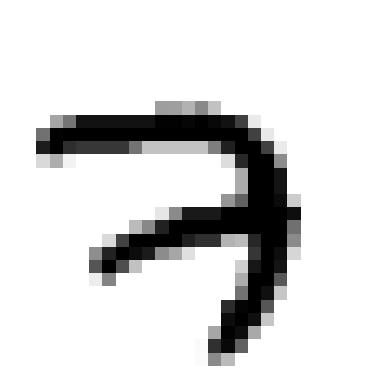

In [96]:
plt.imshow(X_train[0], cmap='binary')
plt.axis("off")
plt.show()

In [97]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

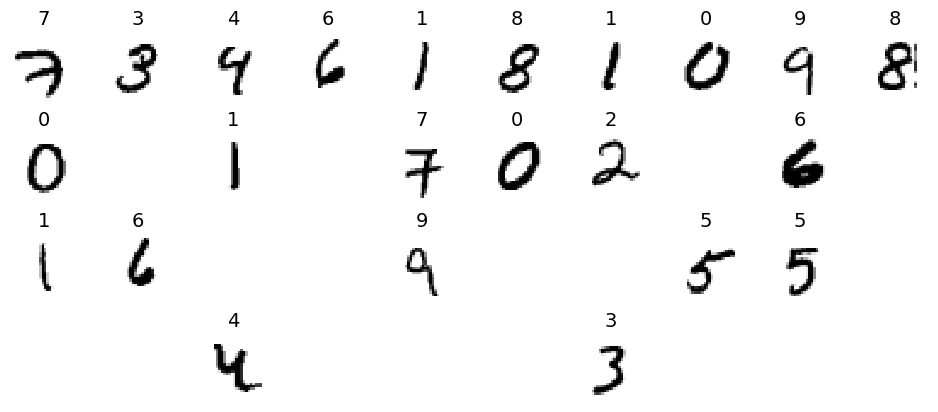

In [98]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        idx = col * row + col
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(X_train[idx], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(y_train[idx])

plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

In [99]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_values(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [100]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [101]:
flatten_layer = tf.keras.layers.Flatten()
hidden_layer1 = tf.keras.layers.Dense(200, activation='relu')
hidden_layer2 = tf.keras.layers.Dense(100, activation='relu')
output_layer = tf.keras.layers.Dense(10, activation="softmax")

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
flattened = flatten_layer(input_)
hidden1 = hidden_layer1(flattened)
hidden2 = hidden_layer2(hidden1)
output = output_layer(hidden2)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [102]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
_________________________________________________________________


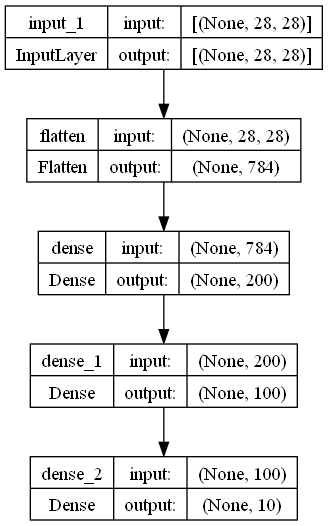

In [103]:
tf.keras.utils.plot_model(model, "mnist_model.png", show_shapes=True)

In [104]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy",
                optimizer='sgd',
                metrics=['accuracy'])

In [105]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6102 - accuracy: 0.8443 - val_loss: 0.3103 - val_accuracy: 0.9148
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2931 - accuracy: 0.9169 - val_loss: 0.2477 - val_accuracy: 0.9302
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2413 - accuracy: 0.9312 - val_loss: 0.2059 - val_accuracy: 0.9420
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2060 - accuracy: 0.9419 - val_loss: 0.1819 - val_accuracy: 0.9504
Epoch 5/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1803 - accuracy: 0.9481 - val_loss: 0.1599 - val_accuracy: 0.9556
Epoch 6/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1604 - accuracy: 0.9546 - val_loss: 0.1468 - val_accuracy: 0.9604
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1441 - accuracy: 0.9593 - val_loss: 0.1342 - val_ac

In [106]:
model = tf.keras.models.load_model("mnist_model")
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0712 - accuracy: 0.9785


[0.07122129946947098, 0.9785000085830688]

In [107]:
%tensorboard --logdir=./my_mnist_logs

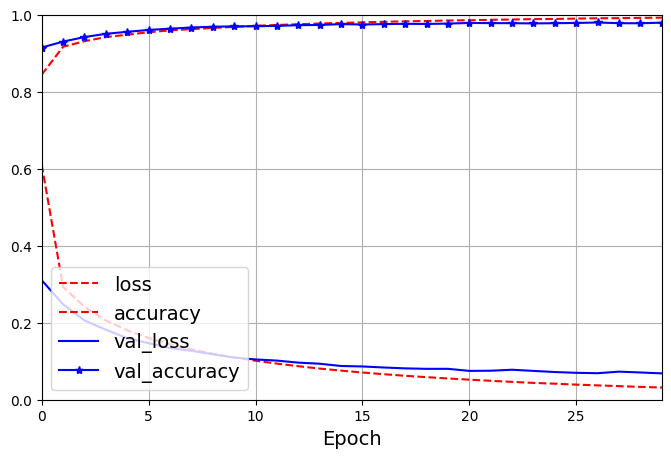

In [108]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*']
)
plt.legend(loc="lower left")
plt.show()